In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# 📥 Load Data
df = pd.read_csv("/kaggle/input/anomaly/anomaly_detection (1).csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").dropna().reset_index(drop=True)

In [3]:
# 🎯 Target: temperature
# 🛠️ Features for Temp Forecast
features_temp = [
    "TDS", "turbidity", "pH", "ph_dev",
    "tds_temp_ratio", "turbidity_x_ph",   # temp_sqr is okay as a helper
    "tds_diff", "ph_diff", "ph_rollstd_3", "tds_rollmean_3"
]

X = df[features_temp]
y = df["temperature"]

In [4]:
# 🔀 Train-Test Split
split_index = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]



In [5]:
# 🚂 Train Model
model_temp = RandomForestRegressor(n_estimators=100, random_state=42)
model_temp.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [6]:
# 🔍 Predict + Evaluate
y_pred = model_temp.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.5f}")

MAE: 0.8578
RMSE: 1.6024
R² Score: 0.94493


/tmp/ipykernel_36/2139155189.py:10: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


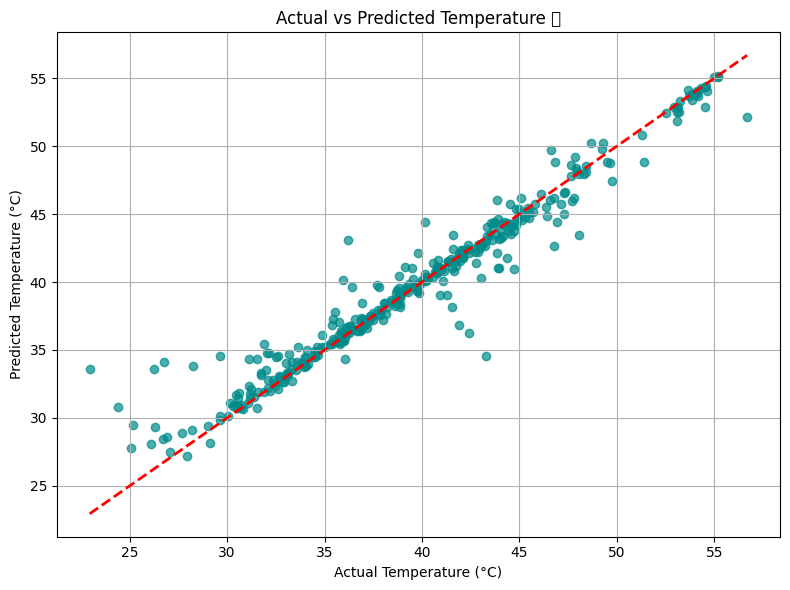

In [7]:
# 📈 Scatter Plot: Actual vs Predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='darkcyan')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted Temperature 🌡️")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# 💾 Save Model
joblib.dump(model_temp, "temp_forecast_model.pkl")

['temp_forecast_model.pkl']

In [9]:
# 🧪 Live Prediction Function
def predict_temperature(tds, turbidity, ph, last_tds=0, last_ph=0,
                        tds_history=[0,0,0], ph_history=[0,0,0]):
    input_data = pd.DataFrame([{
        "TDS": tds,
        "turbidity": turbidity,
        "pH": ph,
        "ph_dev": abs(ph - 7),
        "tds_temp_ratio": tds / 1,  # Temp unknown during prediction, set dummy (model handles it)
        "turbidity_x_ph": turbidity * ph,
        "temp_sqr": 0,  # won't be used at inference (can drop it from final model if needed)
        "tds_diff": tds - last_tds,
        "ph_diff": ph - last_ph,
        "tds_rollmean_3": np.mean(tds_history),
        "ph_rollstd_3": np.std(ph_history)
    }])
    return model_temp.predict(input_data)[0]

# # 🚀 Example Use
# print("🔮 Predicted Temp:", predict_temperature(
#     tds=710, turbidity=12.3, ph=6.95,
#     last_tds=690, last_ph=7.0,
#     tds_history=[690, 705, 710],
#     ph_history=[6.9, 7.0, 6.95]
# ))

In [10]:
def predict_temperature(tds, turbidity, ph, last_tds=0, last_ph=0,
                        tds_history=[0, 0, 0], ph_history=[0, 0, 0]):
    
    input_data = pd.DataFrame([{
        "TDS": tds,
        "turbidity": turbidity,
        "pH": ph,
        "ph_dev": abs(ph - 7),
        "tds_temp_ratio": tds / 1,  # Avoid division by 0
        "turbidity_x_ph": turbidity * ph,
        # "temp_sqr": 0,  # Placeholder; not known in real-time
        "tds_diff": tds - last_tds,
        "ph_diff": ph - last_ph,
        "ph_rollstd_3": np.std(ph_history),
        "tds_rollmean_3": np.mean(tds_history)
    }])

    # Force feature order to match training
    input_data = input_data[[
        "TDS", "turbidity", "pH", "ph_dev",
        "tds_temp_ratio", "turbidity_x_ph", 
        "tds_diff", "ph_diff", "ph_rollstd_3", "tds_rollmean_3"
    ]]

    return model_temp.predict(input_data)[0]

# 🔮 Example Call
predicted_temp = predict_temperature(
    tds=720,
    turbidity=13.5,
    ph=6.95,
    last_tds=700,
    last_ph=7.05,
    tds_history=[700, 710, 720],
    ph_history=[7.0, 7.1, 6.95]
)

print("🔮 Live Predicted Temperature:", round(predicted_temp, 2), "°C")


🔮 Live Predicted Temperature: 31.27 °C


In [11]:
# Predict on entire test set
y_pred = model_temp.predict(X_test)

# See first few predictions vs actuals
comparison_df = pd.DataFrame({
    "Actual Temperature": y_test.values,
    "Predicted Temperature": y_pred
})
print(comparison_df.head(10))


   Actual Temperature  Predicted Temperature
0               38.10                38.4500
1               43.31                43.0280
2               31.18                31.7381
3               53.69                53.6865
4               30.43                31.6679
5               32.88                32.6061
6               54.34                54.2629
7               44.48                43.7650
8               42.35                42.7316
9               32.73                32.9900


/tmp/ipykernel_36/966190927.py:18: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


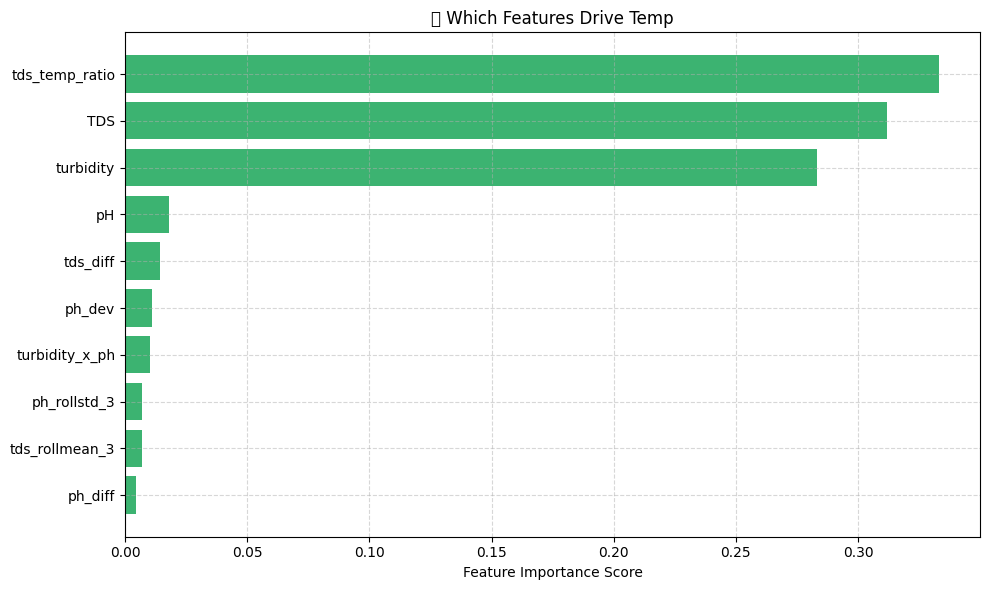

In [12]:
import matplotlib.pyplot as plt

# Get feature importances from trained model
importances = model_temp.feature_importances_
feature_names = X.columns

# Sort them
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_importances[::-1], color='mediumseagreen')
plt.xlabel("Feature Importance Score")
plt.title("🌟 Which Features Drive Temp")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()